# Recurrent Neural Network Implementation From Scratch

Aim is to train a character level model on The Time Machine...

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [9]:
class RNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma
        )
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma
        )
        self.b_h = nn.Parameter(
            torch.zeros(num_hiddens)
        )

    def forward(self, inputs, state=None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)

        else:
            state, = state

        outputs = []

        for X in inputs: # Loop over each timestep (character) of the inputs?|??
            state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)

        return outputs, state
        

In [23]:
batch_size = 2
num_inputs = 16
num_hiddens = 32
num_steps = 100

In [24]:
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))

In [25]:
outputs, state = rnn(X)

In [26]:
def check_len(a, n): #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape): #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
        f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN Based Language Model

Pass RNN as argument to `__init__`, use perplexity to ensure that evaluation is possible over strings of differing lengths. 

In [19]:
class RNNLMScratch(d2l.Classifier):

    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma
        )
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

    def one_hot(self, X):
        # Transpose to have shape (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        # Fully connected to transform outputs into tokens
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

In [29]:
# Check output shape is correct

model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

## Gradient Clipping

RNN's may be thought of as even "deeper" than their static structure may suggest, as they will be run for T timesteps during their use. This exacerbates issues of gradients exploding and vanishing. One commonly used (if inelegant) solution is simply to clip the gradients, forcing them to have a smaller value. Essentially, set some theshold for how large the gradient can be - if it;'s greater than that value, set it to the max allowed. 

In [34]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm 

    

## Training



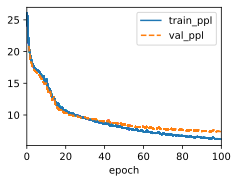

In [35]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Decoding

Once trained, we don't always want to predict just the "next" token, but a series of tokens. We can use the previously generated token as thought it were just the next in the input. We first iterate over a user-provided prompt, updating the hidden state but not actually generating any output, in what is called the _warm up_ period. Then we begin generating output.

In [55]:
@d2l.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]

    for i in range(len(prefix) + num_preds -1):
        # always get the last output
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)

        if i < len(prefix) - 1:
            outputs.append(vocab[prefix[i + 1]])
        else:
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))

    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [64]:
# I mean... it kinda works?

In [56]:
model.predict('it has', 20, data.vocab)

'it has and the the the the'

In [58]:
model.predict("and in the end", 20, data.vocab)

'and in the ending the the the the '

In [63]:
model.predict("peach", 50, data.vocab)

'peach the prace the the the the the the the the the the'

In [65]:
model.predict("the time", 10, data.vocab)

'the time tree the '